# **Datathon GWU - Luis Ahumada**
## Abstract:

The following report attempts to determine the main causes of fatal car accidents in Washington DC. The dataset provided includes 12 independent variables, however, after an exploratory data analysis the models were conducted using only 6 independent variables. The binary classification was performed using three different models: Decision Tree, Logistic Regression and Multi-Layer Perceptron. The best accuracy (99%) was achieved using the decision tree.The best predictors of fatality seemed to be Speeding, Person Type and Vehicle Type.


In [150]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

## **Data Preprocessing**

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
def namestr(obj, namespace):
    '''
    Returns the name of an object.
    Source: https://stackoverflow.com/questions/1538342/how-can-i-get-the-name-of-an-object-in-python
    '''
    return [name for name in namespace if namespace[name] is obj]

pd.set_option('display.max_columns', None)


### Read data

In [153]:
# Specify current working directory:

all_data = pd.read_csv("/content/drive/My Drive/GWU/Datathon/Crash_Details_Table.csv", header=0)

# printing the dataset shape
print(all_data.shape[0])
# printing the dataset shape
print(all_data.shape[1])



596381
15


### Map dependent variable

Mapping each label of the dependent variable.

In [154]:
all_data.loc[all_data.FATAL == "N", 'FATAL'] = 0
all_data.loc[all_data.FATAL == "Y", 'FATAL'] = 1


print(all_data['FATAL'].value_counts())

0    595964
1       417
Name: FATAL, dtype: int64


###Fill Missing values using mode

Filling each missing value using statistical mode.

In [155]:
# all_data = all_data.dropna()

for col in all_data.columns:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# printing the dataset shape
print("Dataset No. of Rows: ", all_data.shape[0])
print("Dataset No. of Columns: ", all_data.shape[1])
print(all_data['FATAL'].value_counts())

Dataset No. of Rows:  596381
Dataset No. of Columns:  15
0    595964
1       417
Name: FATAL, dtype: int64


### Label Enconding

In [156]:
listsString = ['PERSONTYPE', 'MAJORINJURY', 'MINORINJURY', 'INVEHICLETYPE', 'TICKETISSUED', 'IMPAIRED', "SPEEDING", "LICENSEPLATESTATE"]

class_le = LabelEncoder()
for i in listsString:
    all_data[i] = class_le.fit_transform(all_data[i])


## **Common Sense Analysis**

Before the EDA I thought about classifying the variables based on my own judgement of whether a variable should impact fatality or not.




**Variables that should not have any impact on fatality:**

*   OBJECTID
*   CRIMEID
*   CCN
*   PERSON ID
*   VEHICLEID

Due to the descriptive and bureaucratic purpose of these variables it is fair to say they would not have any impact on the seriosuness of a car accident. They are just identifiers of the people and vehicles involved in the accident.



OBJECTID	CRIMEID	CCN	PERSONID	PERSONTYPE	AGE	FATAL	MAJORINJURY	MINORINJURY	VEHICLEID	INVEHICLETYPE	TICKETISSUED	LICENSEPLATESTATE	IMPAIRED	SPEEDING

**Variables that MAYBE affect on whether an accident is Fatal or not:**

*   PERSONTYPE (Whether was a driver, passenger, etc)
*   AGE (Young vs old people tend to drive differently? Risk aversion? Alcohol consumption?)
*   MAJORINJURY (The more serious the injury, the higher chance of a fatal outcome)
*   MINORINJURY	(The more serious the injury, the higher chance of a fatal outcome)
*   INVEHICLETYPE (Vehicle type might affect the outcome of the accident)
*   TICKETISSUED (Whether a fault was commited or not might explain the outcome))
*   LICENSEPLATESTATE (The location of the drivers might explain outcome, for example: newcomers)
*   IMPAIRED 
*   SPEEDING	(Speed)










## **Exploratory Data Analysis**

First, a correlation matrix was displayed. There is no much information to extract from it. Some variables seem the be a little bit correlated between them but the dependent variable (FATAL) seems to be uncorrelated with all the others. This makes sense due to the fact that the dataset is imbalanced.

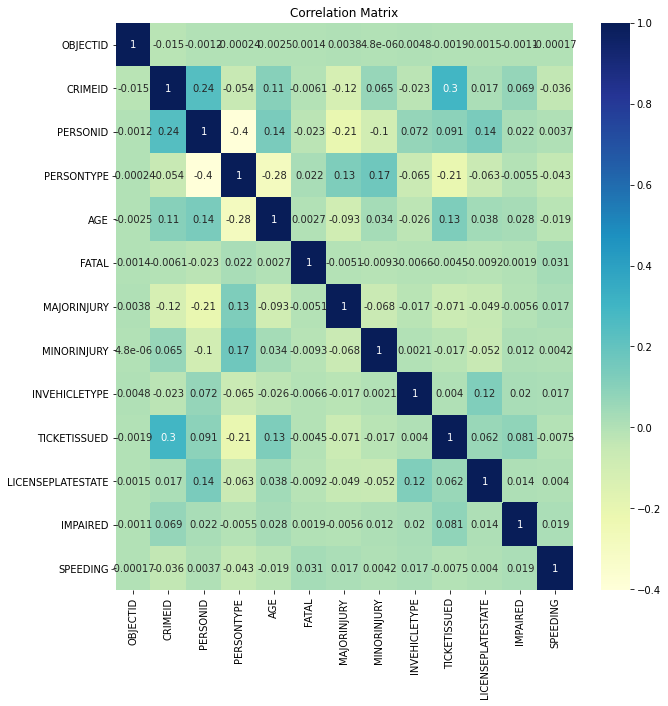

In [157]:
import seaborn as sns
corr = all_data.corr()


plt.subplots(figsize=(10,10))
sns.heatmap(corr.T, annot=True, cmap="YlGnBu")
plt.tight_layout(pad=2, w_pad=0.5, h_pad=0.5)
plt.title("Correlation Matrix")
plt.show()

In [158]:
all_data.describe()

,OBJECTID,CRIMEID,PERSONID,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
count,5.963810e+05,5.963810e+05,5.963810e+05,596381.000000,596381.000000,596381.000000,596381.000000,596381.000000,596381.000000,596381.000000,596381.000000,596381.000000,596381.000000
mean,4.384924e+08,2.672116e+07,8.506922e+07,1.238420,27.669336,0.000699,0.035838,0.110746,14.211504,0.155146,19.980603,0.007965,0.007651
std,1.721813e+05,1.238390e+06,8.613766e+06,0.491526,24.835629,0.026433,0.185886,0.313818,3.209115,0.362044,16.572715,0.088889,0.087136
min,4.370014e+08,2.341134e+07,1.045383e+07,0.000000,-7990.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.383433e+08,2.532167e+07,8.474899e+07,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,9.000000,0.000000,0.000000
50%,4.384924e+08,2.680585e+07,8.497752e+07,1.000000,29.000000,0.000000,0.000000,0.000000,15.000000,0.000000,12.000000,0.000000,0.000000
75%,4.386415e+08,2.769386e+07,8.712287e+07,1.000000,45.000000,0.000000,0.000000,0.000000,15.000000,0.000000,23.000000,0.000000,0.000000
max,4.387906e+08,2.872803e+07,9.077153e+07,3.000000,237.000000,1.000000,1.000000,1.000000,21.000000,1.000000,59.000000,1.000000,1.000000


###Removing outliers in AGE

After seeing a summary of the dataset. We can see that the variable AGE has a few outliers. Numbers that are negative or above 110+ that clearly cannot be defined as someone's age.

In [159]:
q_low = all_data["AGE"].quantile(0.01)
q_hi  = all_data["AGE"].quantile(0.99)

all_data = all_data[(all_data["AGE"] < q_hi) & (all_data["AGE"] > q_low)]

all_data.describe()



,OBJECTID,CRIMEID,PERSONID,PERSONTYPE,AGE,FATAL,MAJORINJURY,MINORINJURY,INVEHICLETYPE,TICKETISSUED,LICENSEPLATESTATE,IMPAIRED,SPEEDING
count,4.069330e+05,4.069330e+05,4.069330e+05,406933.000000,406933.000000,406933.000000,406933.000000,406933.000000,406933.000000,406933.000000,406933.000000,406933.000000,406933.000000
mean,4.384922e+08,2.686853e+07,8.615351e+07,1.141353,39.243175,0.000715,0.020517,0.126608,14.186822,0.191575,21.035748,0.010997,0.007881
std,1.758556e+05,1.200367e+06,2.150082e+06,0.410446,14.663643,0.026732,0.141760,0.332534,3.306911,0.393540,16.002902,0.104288,0.088424
min,4.370014e+08,2.341134e+07,1.045964e+07,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.383364e+08,2.660213e+07,8.477852e+07,1.000000,28.000000,0.000000,0.000000,0.000000,15.000000,0.000000,9.000000,0.000000,0.000000
50%,4.384926e+08,2.703274e+07,8.502615e+07,1.000000,37.000000,0.000000,0.000000,0.000000,15.000000,0.000000,23.000000,0.000000,0.000000
75%,4.386471e+08,2.779098e+07,8.749032e+07,1.000000,50.000000,0.000000,0.000000,0.000000,15.000000,0.000000,23.000000,0.000000,0.000000
max,4.387906e+08,2.872803e+07,9.077153e+07,3.000000,75.000000,1.000000,1.000000,1.000000,21.000000,1.000000,59.000000,1.000000,1.000000


### Density plot by Fatality (Numeric variables)

A useful way to observe the differences in the variables by fatality is using density plot. This type of plot can only be used with numeric variables (continuous data). There are not big differences observed in most of the plot between fatal accidents (blue) and non-fatal (green).

Maybe in the variable InVEHICLETYPE one can see a blue frequency between 8 and 15 higher than green.

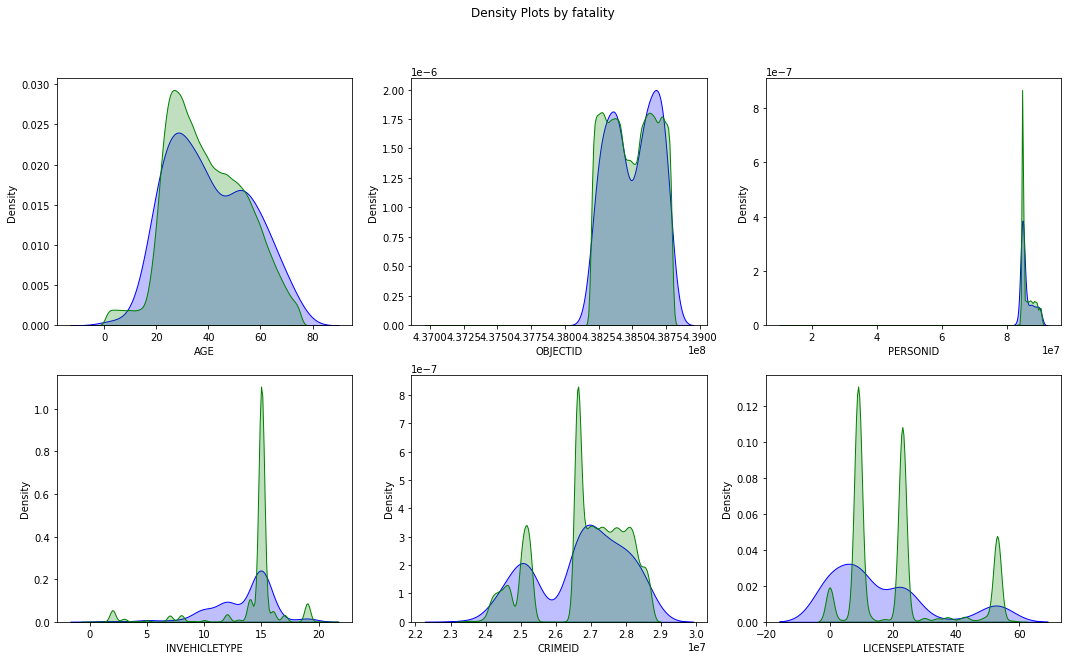

In [160]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Density Plots by fatality')

sns.kdeplot(ax=axes[0, 0], data=all_data[all_data["FATAL"]==1]["AGE"], shade=True, color="blue")
sns.kdeplot(ax=axes[0, 0], data=all_data[all_data["FATAL"]==0]["AGE"], shade=True, color="green")

sns.kdeplot(ax=axes[0, 1], data=all_data[all_data["FATAL"]==1]["OBJECTID"], shade=True, color="blue")
sns.kdeplot(ax=axes[0, 1], data=all_data[all_data["FATAL"]==0]["OBJECTID"], shade=True, color="green")

sns.kdeplot(ax=axes[0, 2], data=all_data[all_data["FATAL"]==1]["PERSONID"], shade=True, color="blue")
sns.kdeplot(ax=axes[0, 2], data=all_data[all_data["FATAL"]==0]["PERSONID"], shade=True, color="green")

sns.kdeplot(ax=axes[1, 0], data=all_data[all_data["FATAL"]==1]["INVEHICLETYPE"], shade=True, color="blue")
sns.kdeplot(ax=axes[1, 0], data=all_data[all_data["FATAL"]==0]["INVEHICLETYPE"], shade=True, color="green")

sns.kdeplot(ax=axes[1, 1], data=all_data[all_data["FATAL"]==1]["CRIMEID"], shade=True, color="blue")
sns.kdeplot(ax=axes[1, 1], data=all_data[all_data["FATAL"]==0]["CRIMEID"], shade=True, color="green")

sns.kdeplot(ax=axes[1, 2], data=all_data[all_data["FATAL"]==1]["LICENSEPLATESTATE"], shade=True, color="blue")
sns.kdeplot(ax=axes[1, 2], data=all_data[all_data["FATAL"]==0]["LICENSEPLATESTATE"], shade=True, color="green")




### Bar plot by Fatality (Categorical variables)

A useful way to observe the differences in the CATEGORICAL variables by fatality is using the bar plots. By looking at the plots and the printed data we can see that MAJOR and MINOR INJURY do not explain the fatality because they only occur in non-fatalities cases.

MAJORINJURY  FATAL
0            0        398293
             1           291
1            0          8349
             1             0
dtype: int64
MINORINJURY  FATAL
0            0        355121
             1           291
1            0         51521
             1             0
dtype: int64
PERSONTYPE  FATAL
0           0          3792
            1             9
1           0        347383
            1           208
2           0         49735
            1            25
3           0          5732
            1            49
dtype: int64
TICKETISSUED  FATAL
0             0        328721
              1           254
1             0         77921
              1            37
dtype: int64
IMPAIRED  FATAL
0         0        402173
          1           285
1         0          4469
          1             6
dtype: int64
SPEEDING  FATAL
0         0        403479
          1           247
1         0          3163
          1            44
dtype: int64


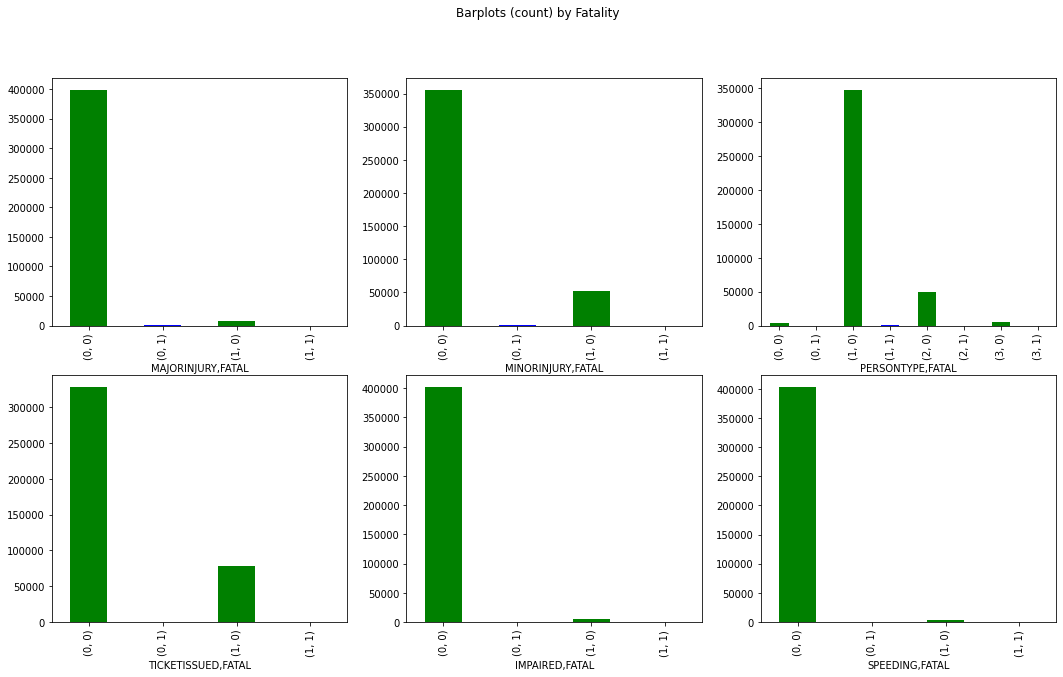

In [161]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Barplots (count) by Fatality')

MajInj = pd.crosstab(index=all_data['MAJORINJURY'], columns=all_data['FATAL']).stack()
print(MajInj)
MajInj.plot(kind="bar", stacked=True, color=["green", "blue"], ax=axes[0, 0])

MinInj = pd.crosstab(index=all_data['MINORINJURY'], columns=all_data['FATAL']).stack()
print(MinInj)
MinInj.plot(kind="bar", stacked=True, color=["green", "blue"], ax=axes[0, 1])

Person = pd.crosstab(index=all_data['PERSONTYPE'], columns=all_data['FATAL']).stack()
print(Person)
Person.plot(kind="bar", stacked=True, color=["green", "blue"], ax=axes[0, 2])

Tick = pd.crosstab(index=all_data['TICKETISSUED'], columns=all_data['FATAL']).stack()
print(Tick)
Tick.plot(kind="bar", stacked=True, color=["green", "blue"], ax=axes[1, 0])

Imp = pd.crosstab(index=all_data['IMPAIRED'], columns=all_data['FATAL']).stack()
print(Imp)
Imp.plot(kind="bar", stacked=True, color=["green", "blue"], ax=axes[1, 1])

Speed = pd.crosstab(index=all_data['SPEEDING'], columns=all_data['FATAL']).stack()
print(Speed)
Speed.plot(kind="bar", stacked=True, color=["green", "blue"], ax=axes[1, 2])

## **Modeling**

### Drop Columns

In [162]:
all_data = all_data.drop(['OBJECTID', 'CRIMEID', 'CCN', 'PERSONID', 'VEHICLEID', "LICENSEPLATESTATE"], axis=1)
# all_data = all_data.dropna()

### Split the dataset

In [163]:
Y = all_data.FATAL
X = all_data.drop('FATAL', axis=1)



### Split the dataset into train and test

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)


### Resampling Train Set

SOURCE: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

In [165]:
# concatenate our training data back together
data = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
no_fatal = data[data.FATAL==0]
fatal = data[data.FATAL==1]

# upsample minority
fatal_upsampled = resample(fatal,
                          replace=True, # sample with replacement
                          n_samples=len(no_fatal), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([fatal_upsampled, no_fatal])

# check new class counts
print(upsampled['FATAL'].value_counts())


print(upsampled.columns)

#Split
y_train = upsampled.values[:, -1]
X_train = upsampled.drop(['FATAL'], axis=1)
X_train = X_train.values


1    325313
0    325313
Name: FATAL, dtype: int64
Index(['PERSONTYPE', 'AGE', 'MAJORINJURY', 'MINORINJURY', 'INVEHICLETYPE',
       'TICKETISSUED', 'IMPAIRED', 'SPEEDING', 'FATAL'],
      dtype='object')


### Standardize the data

In [166]:
stdsc = StandardScaler()

stdsc.fit(X_train)

X_train_std = stdsc.transform(X_train)
X_test_std = stdsc.transform(X_test)




## **MODEL 1: Decision Tree**

In [167]:
# Decision tree with entropy
clf_entropy = DecisionTreeClassifier(criterion="entropy", random_state=100, max_depth=3, min_samples_leaf=5)
# y_train=y_train.astype('int')
# Performing training
clf_entropy.fit(X_train_std, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [168]:
# predicton on test using entropy
y_pred_entropy = clf_entropy.predict(X_test_std)

# calculate metrics gini model
print("\n")
print("Results Using Gini Index: \n")
print("Classification Report: ")
# print(classification_report(y_test,y_pred_entropy))
print("\n")
print("Accuracy : ", accuracy_score(y_test, y_pred_entropy) * 100)
print("\n")
print ('-'*80 + '\n')
# calculate metrics entropy model
print("\n")
print("Results Using Entropy: \n")
print("Classification Report: ")
print(classification_report(y_test,y_pred_entropy))
print("\n")
print("Accuracy : ", accuracy_score(y_test, y_pred_entropy) * 100)
print ('-'*80 + '\n')



Results Using Gini Index: 

Classification Report: 


Accuracy :  99.04775947018565


--------------------------------------------------------------------------------



Results Using Entropy: 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     81329
           1       0.03      0.34      0.05        58

    accuracy                           0.99     81387
   macro avg       0.51      0.67      0.52     81387
weighted avg       1.00      0.99      0.99     81387



Accuracy :  99.04775947018565
--------------------------------------------------------------------------------



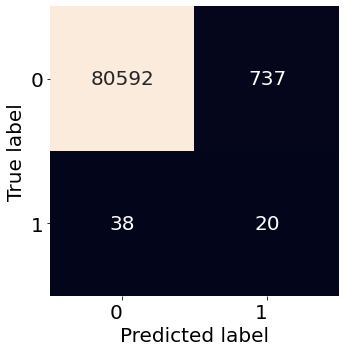

In [169]:
# confusion matrix for entropy model
conf_matrix = confusion_matrix(y_test, y_pred_entropy)
class_names = all_data.FATAL.unique()
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names )

plt.figure(figsize=(5,5))
hm = sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='d', annot_kws={'size': 20}, yticklabels=df_cm.columns, xticklabels=df_cm.columns)
hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.tight_layout()
plt.show()


## **MODEL 2: Logistic Regression**

In [170]:
# perform training
# creating the classifier object
clf = LogisticRegression()

# performing training
clf.fit(X_train, y_train)

# make predictions
# predicton on test
y_pred = clf.predict(X_test)

y_pred_score = clf.predict_proba(X_test)

# calculate metrics
print("\n")

print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("\n")


print("Accuracy : ", accuracy_score(y_test, y_pred) * 100)
print("\n")


logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.71      0.83     81329
           1       0.00      0.64      0.00        58

    accuracy                           0.71     81387
   macro avg       0.50      0.67      0.42     81387
weighted avg       1.00      0.71      0.83     81387



Accuracy :  70.70048042070601


         Current function value: 0.563026
         Iterations: 35
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.188      
Dependent Variable: y                AIC:              732654.9133
Date:               2021-04-05 03:57 BIC:              732745.9988
No. Observations:   650626           Log-Likelihood:   -3.6632e+05
Df Model:           7                LL-Null:          -4.5098e+05
Df Residuals:       650618           LLR p-value:      0.0000     
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000          

## **MODEL 3: MLP Classifier**

--------------------------------------------------------------------------------
Model Results: alphaValue: 0.001 hiddenLayer: 20
--------------------------------------------------------------------------------
Accuracy of MLP 0.745
-
Confusion Matrix :
[[60569 20760]
 [   21    37]]
-
Classification Report MLP :
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     81329
           1       0.00      0.64      0.00        58

    accuracy                           0.74     81387
   macro avg       0.50      0.69      0.43     81387
weighted avg       1.00      0.74      0.85     81387

-
Y_pred : [0. 0. 0. ... 0. 0. 0.]
-


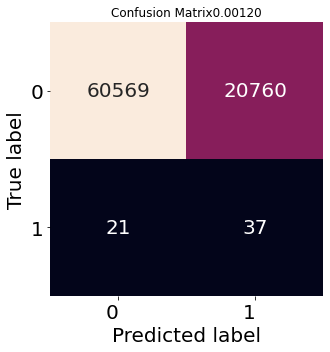

--------------------------------------------------------------------------------
Model Results: alphaValue: 0.001 hiddenLayer: 10
--------------------------------------------------------------------------------
Accuracy of MLP 0.98
-
Confusion Matrix :
[[79743  1586]
 [   38    20]]
-
Classification Report MLP :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     81329
           1       0.01      0.34      0.02        58

    accuracy                           0.98     81387
   macro avg       0.51      0.66      0.51     81387
weighted avg       1.00      0.98      0.99     81387

-
Y_pred : [0. 0. 0. ... 0. 0. 0.]
-


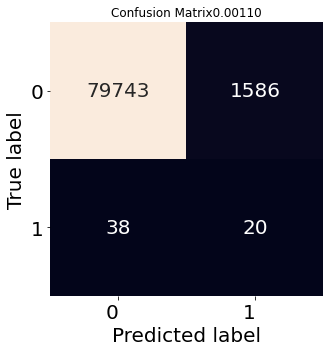

In [ ]:
hiddenLayers = (20, 10)
alpha = (0.001, 0.01)

for i in alpha:
    for j in hiddenLayers:

        name = i
        # Create a MLP Classifier
        clf = MLPClassifier(solver='adam',
                            alpha=i,
                            hidden_layer_sizes=(j,7,5,3),
                            random_state=1)
        # Train the model using the training sets
        clf.fit(X_train_std, y_train)
        # Predict the response for test dataset
        y_pred = clf.predict(X_test_std)



        print("-" * 80)
        print("Model Results:", "alphaValue:", i, "hiddenLayer:", j)
        print("-" * 80)
        print("Accuracy of MLP", round(metrics.accuracy_score(y_test, y_pred), 3))
        print("-")
        print("Confusion Matrix", ":")
        cmx_MLP = confusion_matrix(y_test, y_pred)
        print(cmx_MLP)
        print("-")
        print("Classification Report MLP", ":")
        cfrp = classification_report(y_test, y_pred)
        print(cfrp)
        print("-")
        print("Y_pred", ":", y_pred)
        print("-")

        # confusion matrix for entropy model
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_names = all_data.FATAL.unique()
        df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

        plt.figure(figsize=(5, 5))
        hm = sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='d', annot_kws={'size': 20},
                         yticklabels=df_cm.columns, xticklabels=df_cm.columns)
        hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
        hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
        plt.ylabel('True label', fontsize=20)
        plt.xlabel('Predicted label', fontsize=20)
        plt.title("Confusion Matrix" + str(i) + str(j))
        plt.tight_layout()
        plt.show()

## **Interpretation & Key Findings**

In [ ]:
The model was pretty accurate to predict. It is consistent with wwhat the literature says about car crashes. Speeding and Age are major factors. According to a recent report published in Bamk Rate about Car Crash statistics: https://www.bankrate.com/insurance/car/car-crash-statistics/
